In [229]:
# !wget http://pages.cs.wisc.edu/~csverma/CS766_09/ImageMosaic/apple.jpg
# !wget http://pages.cs.wisc.edu/~csverma/CS766_09/ImageMosaic/orange.jpg

In [23]:
import requests
from matplotlib import pyplot as plt
import cv2
import numpy as np

In [5]:
apple = 'http://pages.cs.wisc.edu/~csverma/CS766_09/ImageMosaic/apple.jpg'
orange = 'http://pages.cs.wisc.edu/~csverma/CS766_09/ImageMosaic/orange.jpg'

apple = requests.get(apple)
with open('apple.jpg', 'wb') as f:
    f.write(apple.content)

orange = requests.get(orange)
with open('orange.jpg', 'wb') as f:
    f.write(orange.content)
    
apple = plt.imread('apple.jpg')
orange = plt.imread('orange.jpg')

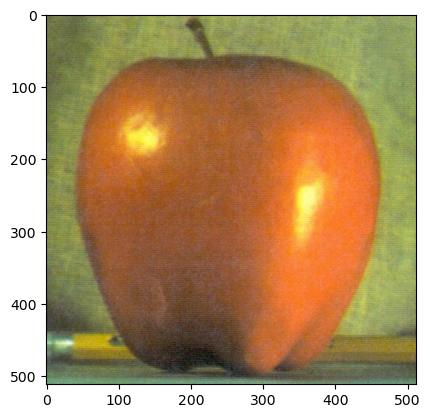

In [16]:
plt.imshow(apple)

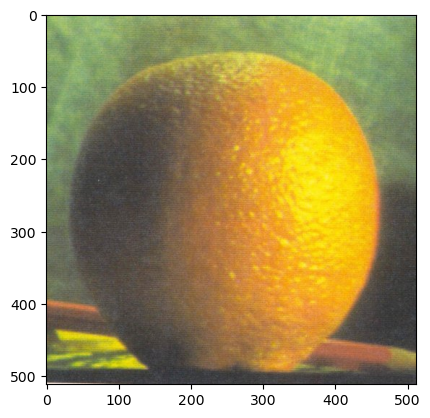

In [17]:
plt.imshow(orange)

# Image Blending

In this assignment you should implement the blending of the two images. You can download images with the cell above.

In order to blend the images, you should follow the following steps:

1. Construct the Laplacian Pyramids for each image
2. Now we should blend two pyramids: construct the third pyramid where you take first half of the image from the left pyramid and second half of the image from the right pyramid.
3. Reconstruct the original image with the new merged pyramid

You should obtain the following result:

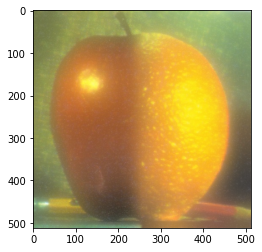

In [150]:
# Gaussian pyramid for apple

def gauss_pyramid(img, depth):
    img_ = img.copy()
    g_pyramid = [img_]
    
    for i in range(depth):
        img_ = cv2.pyrDown(img_)
        g_pyramid.append(img_)

    return g_pyramid

In [151]:
gpyr_apple = gauss_pyramid(apple, 6)
gpyr_orange = gauss_pyramid(orange, 6)

In [152]:
# Laplasian pyramid for apple

def laplas_pyramid(g_pyramid):
    num_layer = len(g_pyramid) - 2
    laplas_pyramid = [g_pyramid[num_layer]]

    for i in range(num_layer, 0, -1):
        layerup = cv2.pyrUp(g_pyramid[i])
        laplas = cv2.subtract(g_pyramid[i-1], layerup)
        laplas_pyramid.append(laplas)

    return laplas_pyramid

In [153]:
lp_apple = laplas_pyramid(gpyr_apple)
lp_orange = laplas_pyramid(gpyr_orange)

In [154]:
# Now add left and right halves of images in each level

apporange = []

for la, lo in zip(lp_apple, lp_orange):
    rows,cols, dep = la.shape
    res = np.hstack((la[:, 0:cols//2], lo[:, cols//2:]))
    apporange.append(res)

In [155]:
# now reconstruct

ls_ = apporange[0]
for i in range(1,6):
    ls_ = cv2.pyrUp(ls_)
    ls_ = cv2.add(ls_, apporange[i])

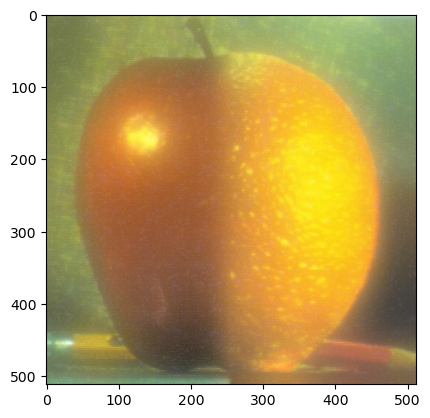

In [156]:
# image with direct connecting each half

plt.imshow(ls_)

In [143]:
eye = 'https://surfertas.github.io/static/img/posts/eye.png'
mask = 'https://surfertas.github.io/static/img/posts/mask.png'
hand = 'https://surfertas.github.io/static/img/posts/hand.png'

urls = [eye, mask, hand]

for url in urls:
    response = requests.get(url)
    with open(f'{url.split("/")[-1]}', 'wb') as f:
        f.write(response.content)

# Image Blending with Mask

In general, we can have an arbirtary mask and blend two images according to this mask. The procedure is the following:

1. Construct laplacian pyramids for 2 images that you want to blend
2. Construct gaussian pyramid for a mask
3. Compute weighted sum for each level of the pyramid
$$
L = L_1 \alpha + L_2 (1 - \alpha)
$$

4. Reconstruct the image from the blended pyramid

You should obtain the following result.

In [157]:
hand = plt.imread('hand.png')
mask = plt.imread('mask.png')
eye = plt.imread('eye.png')

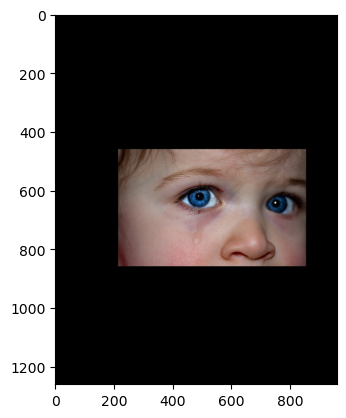

In [158]:
plt.imshow(eye)

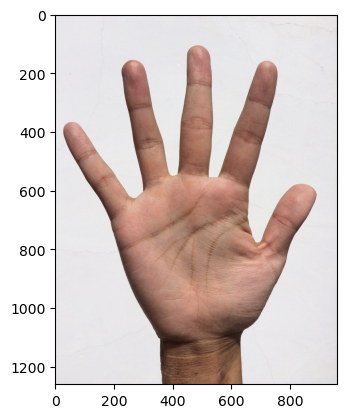

In [159]:
plt.imshow(hand)

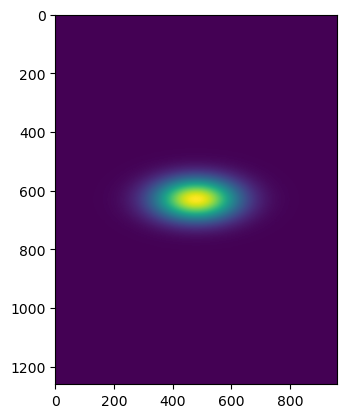

In [147]:
plt.imshow(mask)

In [168]:
# Construct laplacian pyramids for 2 images that you want to blend

gp_hand = gauss_pyramid(hand, 2)
gp_eye = gauss_pyramid(eye, 2)

lp_hand = laplas_pyramid(gp_hand)
lp_eye = laplas_pyramid(gp_eye)

In [207]:
# Construct gaussian pyramid for a mask

gp_mask = gauss_pyramid(mask, 1)[::-1]

In [210]:
def weighted_pyramid(l1, l2, alpha):
    weighted_pyram = []
    
    for l, r, al in zip(l1, l2, alpha):
        blended = l * al[:, :, np.newaxis] + r * ((1 - al)[:, :, np.newaxis])
        weighted_pyram.append(blended)
        
    return weighted_pyram

In [226]:
w_pyr = weighted_pyramid(lp_eye, lp_hand, gp_mask)

In [227]:
# now reconstruct
layer = len(w_pyr)

ls_ = w_pyr[0]
for i in range(1, layer):
    ls_ = cv2.pyrUp(ls_)
    ls_ = cv2.add(ls_, w_pyr[i])

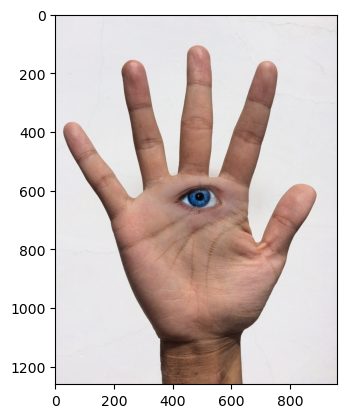

In [228]:
plt.imshow(ls_)
plt.show()